# preparation

In [1]:
import pandas as pd
import numpy as np

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold

# 評価指標
from sklearn.metrics import mean_squared_error
import sys
sys.path.append('./evaluation')
from rmse import rmse
from recall5 import recall5
from profit import profit

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#保存
import pickle

In [2]:
#データを読み込む
n_uma_race_df = pd.read_pickle('../datasets/traindata/n_uma_race.pkl')
n_race_df = pd.read_pickle('../datasets/traindata/n_race.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

# LightGBM

## グループクエリ用のカラムを作成

In [3]:
# 新しいグループを作成
n_uma_race_df['group'] = n_uma_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_uma_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_uma_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_uma_race_df['race_bango'].astype(int).astype(str)
n_race_df['group'] = n_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_race_df['race_bango'].astype(int).astype(str)
n_payout_df['group'] = n_payout_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_payout_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_payout_df['keibajo_code'].astype(int).astype(str) +"-"+  n_payout_df['race_bango'].astype(int).astype(str)

n_race_df_drop = n_race_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango'],axis=1)
n_payout_df_drop = n_payout_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango', 'toroku_tosu', 'shusso_tosu'],axis=1)

merged_df = pd.merge(n_uma_race_df, n_race_df_drop, on='group', how='left')
merged_df = pd.merge(merged_df, n_payout_df_drop, on='group', how='left')
merged_df['group'].nunique()

205318

In [4]:
merged_df = merged_df[merged_df['ijo_kubun_code'] == 0]
# 1	出走取消	取消	SCRATCHED	S

In [5]:
columns_to_convert = [
            'kaisai_nen',
            'kaisai_tsukihi',
            'keibajo_code',
            # 'kaisai_kai',
            # 'kaisai_nichime',
            'race_bango',
            'wakuban',
            'umaban',
            'ketto_toroku_bango',
            # 'bamei',
            'umakigo_code',
            'seibetsu_code',
            'hinshu_code',
            'moshoku_code',
            'barei',
            'tozai_shozoku_code',
            'chokyoshi_code',
            'banushi_code',
            # 'banushimei',
            'futan_juryo',
            'blinker_shiyo_kubun',
            'kishu_code',
            # 'kishumei_ryakusho',
            'kishu_minarai_code',
            'bataiju',
            'zogen_fugo',
            'zogen_sa',
            'ijo_kubun_code',
            # 'nyusen_juni',
            ## 'kakutei_chakujun',
            # 'dochaku_kubun',
            # 'dochaku_tosu',
            # 'soha_time',
            # 'chakusa_code_1',
            # 'chakusa_code_2',
            # 'chakusa_code_3',
            # 'corner_1',
            # 'corner_2',
            # 'corner_3',
            # 'corner_4',
            # 'tansho_odds',
            # 'tansho_ninkijun',
            # 'kakutoku_honshokin',
            # 'kakutoku_fukashokin',
            # 'kohan_4f',
            # 'kohan_3f',
            # 'aiteuma_joho_1',
            # 'aiteuma_joho_2',
            # 'aiteuma_joho_3',
            # 'time_sa',
            # 'record_koshin_kubun',
            # 'kyakushitsu_hantei',
                    ]

for column in columns_to_convert:
    merged_df[column].fillna(0, inplace=True)
    try:
        if merged_df[column].astype(float).apply(lambda x: x.is_integer()).all():
            merged_df[column] = merged_df[column].astype(int)
        else:
            merged_df[column] = merged_df[column].astype(float)
    except ValueError:
        merged_df[column] = merged_df[column].astype(float)

    print(f"{column} のデータ型: {merged_df[column].dtype}")

kaisai_nen のデータ型: int32
kaisai_tsukihi のデータ型: int32
keibajo_code のデータ型: int32
race_bango のデータ型: int32
wakuban のデータ型: int32
umaban のデータ型: int32
ketto_toroku_bango のデータ型: int32
umakigo_code のデータ型: int32
seibetsu_code のデータ型: int32
hinshu_code のデータ型: int32
moshoku_code のデータ型: int32
barei のデータ型: int32
tozai_shozoku_code のデータ型: int32
chokyoshi_code のデータ型: int32
banushi_code のデータ型: int32
futan_juryo のデータ型: int32
blinker_shiyo_kubun のデータ型: int32
kishu_code のデータ型: int32
kishu_minarai_code のデータ型: int32
bataiju のデータ型: int32
zogen_fugo のデータ型: int32
zogen_sa のデータ型: int32
ijo_kubun_code のデータ型: int32


## LightGBM

### テスト用と学習用のデータに分け、モデルを作成

In [6]:
# 2010年から2019年のデータを学習データとして取得
train_data = merged_df[merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
test_data = merged_df[merged_df['kaisai_nen'].isin([2020, 2021, 2022])]

In [7]:
# ランキング学習のために必要な特徴量とターゲットを設定
features = [
            'seibetsu_code',
            'moshoku_code',
            'barei',
            'chokyoshi_code',
            'banushi_code',
            'kishu_code',
            'kishu_minarai_code',
            'kyoso_shubetsu_code',
            'juryo_shubetsu_code',
            'futan_juryo',
            'bataiju',
            'zogen_fugo',
            'zogen_sa',
            ]


target = 'kakutei_chakujun'

# LightGBM用のデータセットを作成
train_dataset = lgb.Dataset(train_data[features], label=train_data[target])

# LightGBMのパラメータを設定
params = {
    'objective': 'regression',
    'metric': 'rmse', 
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# k=5のFOLDでデータを分割
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 各FOLDでのモデルを保存するためのリスト
models = []

# LightGBMモデルを訓練
for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
    valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
    
    model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=100)
    models.append(model)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 1168487, number of used features: 13
[LightGBM] [Info] Start training from score 5.544397
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.98028
[200]	valid_0's rmse: 2.95595
[300]	valid_0's rmse: 2.94427
[400]	valid_0's rmse: 2.93507
[500]	valid_0's rmse: 2.92777
[600]	valid_0's rmse: 2.92244
[700]	valid_0's rmse: 2.91839
[800]	valid_0's rmse: 2.91438
[900]	valid_0's rmse: 2.9107
[1000]	valid_0's rmse: 2.90744
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.90744
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028978 seconds.
You can set `force_row_wise=true` to remo

### テストデータで予測

In [8]:
# 2020年から2022年のテストデータを取得
test_data_2020 = merged_df[merged_df['kaisai_nen'] == 2020].copy()
test_data_2021 = merged_df[merged_df['kaisai_nen'] == 2021].copy()
test_data_2022 = merged_df[merged_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

,group,predicted_rank,kakutei_chakujun
1635601,2021-222-83-2,3.0,6
1635602,2021-222-83-2,5.0,7
1635603,2021-222-83-2,10.0,1
1635604,2021-222-83-2,4.0,2
1635605,2021-101-45-1,7.0,1
...,...,...,...
1785604,2021-1231-54-11,10.0,3
1785605,2021-1231-54-11,3.0,1
1785606,2021-1231-54-11,7.0,2
1785607,2021-1231-54-11,4.0,11


## モデル評価

In [9]:
test_datas = [test_data_2020, test_data_2021, test_data_2022]
years = [2020, 2021, 2022]

In [10]:
rmse(test_datas, years)

RMSE for 2020: 3.644
RMSE for 2021: 3.729
RMSE for 2022: 3.716
Mean RMSE: 3.697


In [11]:
recall5(test_datas, years)

2020 Precision@5: 38.675%
2020 Recall@5: 64.459%
2021 Precision@5: 38.132%
2021 Recall@5: 63.553%
2022 Precision@5: 38.001%
2022 Recall@5: 63.335%


In [12]:
profit(test_datas, years)

2020 Average Net Profit: -321.836 yen
2021 Average Net Profit: -390.237 yen
2022 Average Net Profit: -372.785 yen
Mean Average Net Profit: -361.619 yen


### 予測を見る

In [13]:
# # ```
# # すべての予測を見たい時用（処理時間かかる）
# # ```

# #グループごとの予測値と実際値を見てみる
# for group_id in group_ids_2021:
#     test_data = test_data_2021[test_data_2021['group'] == group_id]
#     sorted_test_data = test_data.sort_values(by='kakutei_chakujun')
#     print(sorted_test_data[['group', 'predicted_rank', 'kakutei_chakujun']])

# モデル保存

In [14]:
# モデルを保存
with open('bestmodels/benchmark.pkl', 'wb') as f:
    pickle.dump(models, f)

# 分析

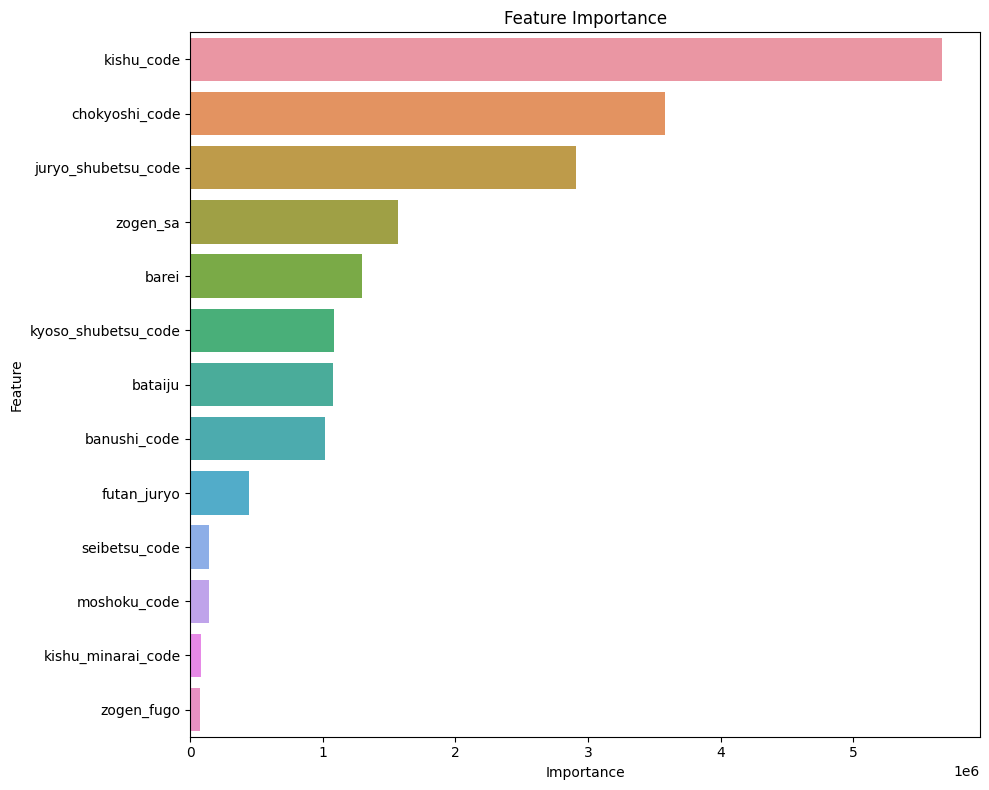

In [15]:
# models[0]の特徴量の重要度を取得
feature_importance = models[0].feature_importance(importance_type='gain')

# 特徴量の名前と重要度をDataFrameに変換
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# 重要度の降順にソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# プロット
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

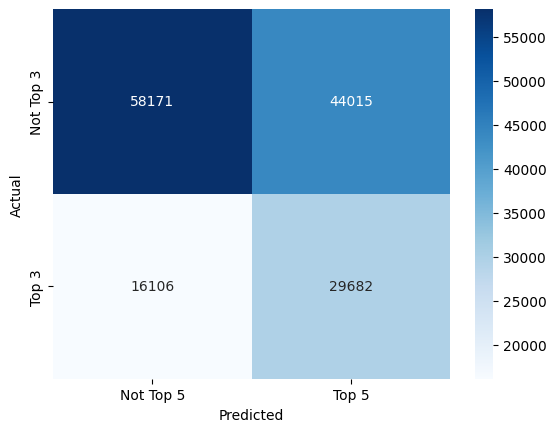

In [16]:
# 予測ランキングの上位5頭を1、それ以外を0とする
test_data_2021.loc[:, 'predicted_top5'] = test_data_2021.groupby('group')['y_pred'].rank(ascending=True).apply(lambda x: 1 if x <= 5 else 0)

# 実際のランキングの上位3頭を1、それ以外を0とする
test_data_2021.loc[:, 'actual_top3'] = test_data_2021['kakutei_chakujun'].apply(lambda x: 1 if x <= 3 else 0)

# Confusion Matrixを計算
cm = confusion_matrix(test_data_2021['actual_top3'], test_data_2021['predicted_top5'])

# Confusion Matrixを表示
x_label = ['Not Top 5', 'Top 5']
y_label = ['Not Top 3', 'Top 3']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=x_label, yticklabels=y_label)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
#正解したレースの特徴を調べる

In [18]:
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'y_pred').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000

In [19]:
successful_groups = test_data_2021.groupby('group').apply(check_top3_in_top5_predictions)
successful_races = test_data_2021[test_data_2021['group'].isin(successful_groups[successful_groups].index)]

In [20]:
successful_races

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,...,fuseiritsu_flag_sanrenpuku,tokubarai_flag_sanrenpuku,henkan_flag_sanrenpuku,haraimodoshi_sanrenpuku_1a,haraimodoshi_sanrenpuku_1b,haraimodoshi_sanrenpuku_1c,y_pred,predicted_rank,predicted_top5,actual_top3
1635681,2021,101,45,12,1,7,1,1,2015101195,トミノヴェール,...,0.0,0.0,0.0,60812.0,290.0,1.0,7.334385,12.0,0,0
1635682,2021,101,45,12,1,7,2,2,2017104323,グローリアスグナー,...,0.0,0.0,0.0,60812.0,290.0,1.0,5.378511,2.0,1,0
1635683,2021,101,45,12,1,7,3,3,2017106670,ヒガシブレーヴ,...,0.0,0.0,0.0,60812.0,290.0,1.0,7.073784,9.0,0,0
1635684,2021,101,45,12,1,7,4,4,2017102738,スカイクリアー,...,0.0,0.0,0.0,60812.0,290.0,1.0,6.775430,7.0,0,0
1635685,2021,101,45,12,1,7,5,5,2017101875,チンクエテッレ,...,0.0,0.0,0.0,60812.0,290.0,1.0,6.217709,6.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785591,2021,1231,54,12,5,10,3,3,2017105657,エルサフィーロ,...,0.0,0.0,0.0,10205.0,1480.0,6.0,4.185670,1.0,1,0
1785592,2021,1231,54,12,5,10,4,4,2013102199,ペネトラーレ,...,0.0,0.0,0.0,10205.0,1480.0,6.0,5.623785,5.0,1,0
1785593,2021,1231,54,12,5,10,5,5,2014103429,アイアンブルー,...,0.0,0.0,0.0,10205.0,1480.0,6.0,5.212389,3.0,1,1
1785594,2021,1231,54,12,5,10,6,6,2012105108,ハーツジュニア,...,0.0,0.0,0.0,10205.0,1480.0,6.0,6.558945,7.0,0,0


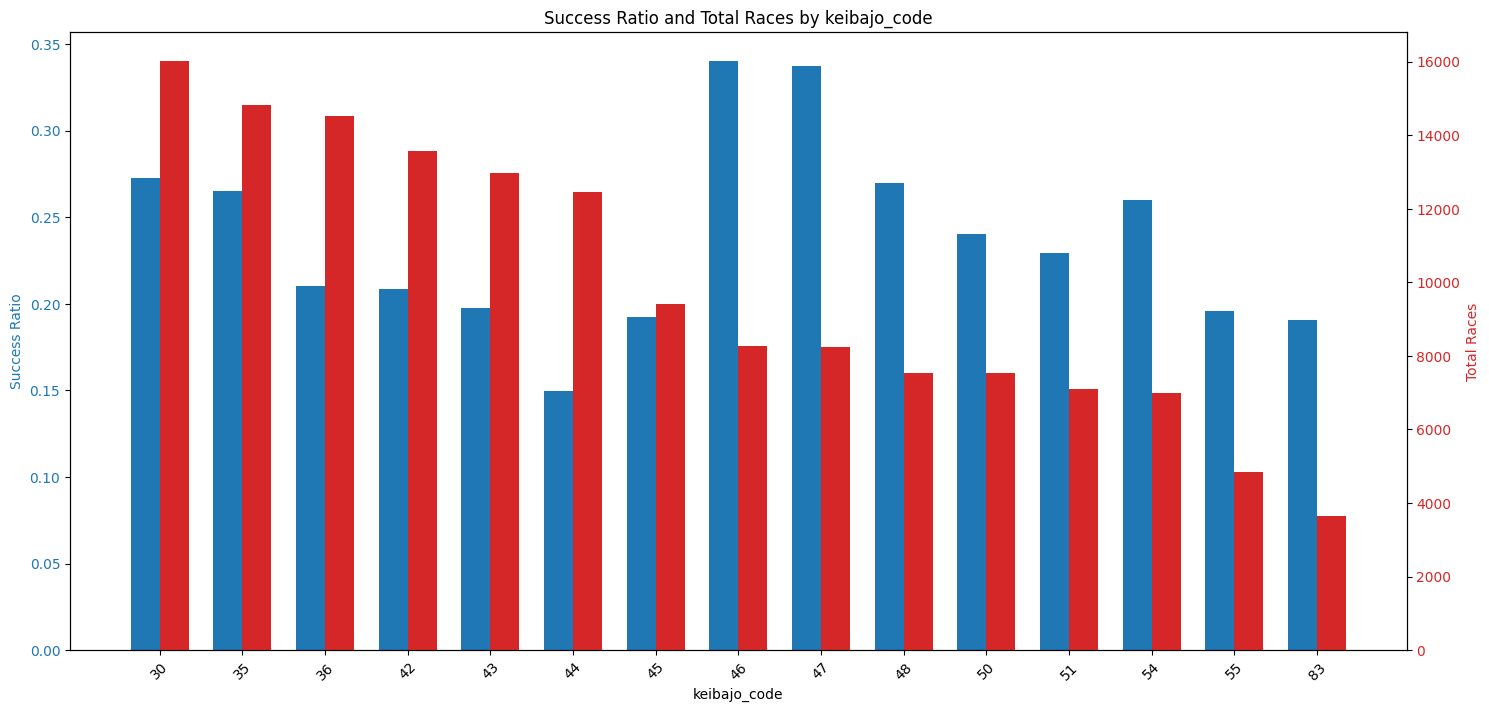

In [21]:
# 全体のJyoCDの分布を取得
total_counts = test_data_2021['keibajo_code'].value_counts()

# successful_racesの中のJyoCDの分布を取得
success_counts = successful_races['keibajo_code'].value_counts()

# 正解したレースの割合を計算
success_ratio = success_counts / total_counts

# データを双方向の棒グラフで可視化
labels = success_ratio.index
x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(15, 7))

color = 'tab:blue'
ax1.set_xlabel('keibajo_code')
ax1.set_ylabel('Success Ratio', color=color)
ax1.bar(x - width/2, success_ratio, width, color=color, label='Success Ratio')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Races', color=color)
ax2.bar(x + width/2, total_counts, width, color=color, label='Total Races')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Success Ratio and Total Races by keibajo_code')
plt.show()

In [22]:
# # 各競馬場での成功したレースの支払いを合計
# total_payouts = successful_payout_2021.groupby('keibajo_code')['haraimodoshi_sanrenpuku_1b'].sum()

# # 各競馬場での投資額を計算
# total_investments = test_data_2021['keibajo_code'].value_counts() * 1000

# # 各競馬場での純利益を計算
# net_profits = total_payouts - total_investments 

# # データを棒グラフで可視化
# net_profits.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), color='lightcoral')
# plt.title('Net Profit by keibajo_code')
# plt.xlabel('keibajo_code')
# plt.ylabel('Net Profit')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [23]:
total_payouts

NameError: name 'total_payouts' is not defined

In [ ]:
total_investments

In [ ]:
net_profits

In [ ]:
def objective(trial):
    # Optunaで調整するパラメータを設定
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
    }
    
    # k=5のFOLDでデータを分割
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 各FOLDでの評価値を保存するためのリスト
    rmses = []
    
    # LightGBMモデルを訓練
    for train_index, valid_index in kf.split(train_data):
        train_fold_data = train_data.iloc[train_index]
        valid_fold_data = train_data.iloc[valid_index]
        
        train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
        valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
        
        model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=100)
        
        # RMSEを計算して保存
        y_pred = model.predict(valid_fold_data[features])
        rmse = np.sqrt(mean_squared_error(valid_fold_data[target], y_pred))
        rmses.append(rmse)
    
    # 5-FOLDの平均RMSEを返す
    return np.mean(rmses)

# Optunaでのパラメータ探索を実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 最適なパラメータ
best_params = study.best_params
best_params['metric'] = 'rmse'  # ここでmetricを追加

# KFoldでのモデル訓練
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
    valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
    
    model = lgb.train(best_params, train_dataset, num_boost_round=500, valid_sets=[valid_dataset], early_stopping_rounds=20, verbose_eval=100)  # ここでearly_stopping_roundsを50に変更
    models.append(model)

In [ ]:
# 2020年から2022年のテストデータを取得
test_data_2020 = merged_df[merged_df['kaisai_nen'] == 2020].copy()
test_data_2021 = merged_df[merged_df['kaisai_nen'] == 2021].copy()
test_data_2022 = merged_df[merged_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

In [ ]:
rmse(test_datas, years)

In [ ]:
recall5(test_datas, years)

In [ ]:
profit(test_datas, years)

In [ ]:
# モデルを保存
with open('bestmodels/benchmark_optunaed.pkl', 'wb') as f:
    pickle.dump(models, f)